In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
targets = pd.read_csv('target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)
data['TARGET_B'].value_counts()

TARGET_B
0    90569
1     4843
Name: count, dtype: int64

In [3]:
data.shape

(95412, 339)

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
#data.isna().sum()

In [6]:
data.columns

Index(['TCODE', 'AGE', 'INCOME', 'WEALTH1', 'HIT', 'MALEMILI', 'MALEVET',
       'VIETVETS', 'WWIIVETS', 'LOCALGOV',
       ...
       'MINRDATE_YR', 'MINRDATE_MM', 'MAXRDATE_YR', 'MAXRDATE_MM',
       'LASTDATE_YR', 'LASTDATE_MM', 'FIRSTDATE_YR', 'FIRSTDATE_MM',
       'TARGET_B', 'TARGET_D'],
      dtype='object', length=339)

In [7]:
y = data['TARGET_B']
X = data.drop(['TARGET_B','TARGET_D'], axis = 1) # TARGET_D???

#### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numericalX_train   = X_train[numerical.columns] 
numericalX_test    = X_test[numerical.columns] 
categoricalX_train = X_train[categorical.columns] 
categoricalX_test  = X_test[categorical.columns] 

In [10]:
print(numericalX_train.shape)
print(numericalX_test.shape)
print(categoricalX_train.shape)
print(categoricalX_test.shape)

(76329, 315)
(19083, 315)
(76329, 22)
(19083, 22)


In [11]:
# we OneHotEncode the categoricals so we can use the same dataset to perform a regression later (in the lab).
# it is not needed for a DecisionTree or RandomForest model
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore', drop='first').fit(categoricalX_train)
encoded_categorical_train = encoder.transform(categoricalX_train).toarray()
encoded_categorical_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out()) # needed to avoid error
encoded_categorical_test = encoder.transform(categoricalX_test).toarray()
encoded_categorical_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out())

/Users/vidhya/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
# we scale the numericals so we can use the same dataset to perform a regression later (in the lab).
# it is not needed for a DecisionTree or RandomForest model
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(numericalX_train)
scaled_numerical_train = transformer.transform(numericalX_train)
scaled_numerical_train = pd.DataFrame(scaled_numerical_train, columns=numericalX_train.columns)
scaled_numerical_test  = transformer.transform(numericalX_test)
scaled_numerical_test  = pd.DataFrame(scaled_numerical_test, columns=numericalX_train.columns)

In [13]:
X_train_treated = pd.concat([scaled_numerical_train, encoded_categorical_train], axis = 1)
X_test_treated  = pd.concat([scaled_numerical_test,  encoded_categorical_test],  axis = 1)

In [14]:
#reset y_train, y_test index because when encoding is done, the index will be reset
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
display(X_train_treated.head())
display(y_train)

TCODE       AGE    INCOME   WEALTH1       HIT  MALEMILI   MALEVET  \
0  0.000017  0.762887  0.500000  0.666667  0.008299  0.000000  0.313131   
1  0.000000  0.536082  0.666667  1.000000  0.000000  0.000000  0.292929   
2  0.000017  0.608247  0.666667  0.111111  0.020747  0.000000  0.424242   
3  0.000017  0.783505  0.833333  0.666667  0.037344  0.010101  0.404040   
4  0.000052  0.556701  0.666667  0.222222  0.087137  0.333333  0.272727   

   VIETVETS  WWIIVETS  LOCALGOV  STATEGOV    FEDGOV   WEALTH2    POP901  \
0  0.101010  0.686869  0.060606  0.121212  0.034483  1.000000  0.007153   
1  0.242424  0.383838  0.070707  0.080808  0.045977  1.000000  0.045856   
2  0.161616  0.626263  0.101010  0.020202  0.011494  0.111111  0.067304   
3  0.232323  0.414141  0.080808  0.030303  0.045977  0.666667  0.014063   
4  0.292929  0.181818  0.121212  0.020202  0.080460  1.000000  0.010040   

     POP902    POP903   POP90C1  POP90C2   POP90C3   POP90C4   POP90C5  \
0  0.009129  0.007683  1.000000      0.0  0.000000  0.474747  0.535354   
1  0.055403  0.044968  0.000000      0.0  1.000000  0.494949  0.515152   
2  0.091154  0.087309  1.000000      0.0  0.000000  0.454545  0.555556   
3  0.017853  0.013728  1.000000      0.0  0.000000  0.494949  0.515152   
4  0.012052  0.010988  0.939394      0.0  0.070707  0.505051  0.505051   

       ETH1      ETH2      ETH3      ETH4      ETH5  ETH6      ETH7      ETH8  \
0  0.757576  0.212121  0.000000  0.020202  0.020202   0.0  0.000000  0.000000   
1  0.757576  0.161616  0.090909  0.000000  0.010101   0.0  0.000000  0.000000   
2  0.989899  0.000000  0.000000  0.010101  0.020202   0.0  0.000000  0.000000   
3  0.787879  0.010101  0.010101  0.151515  0.111111   0.0  0.013889  0.050505   
4  0.888889  0.080808  0.000000  0.030303  0.040404   0.0  0.000000  0.000000   

       ETH9     ETH10     ETH11     ETH12     ETH13     ETH14  ETH15  \
0  0.000000  0.000000  0.021277  0.000000  0.000000  0.017544    0.0   
1  0.000000  0.000000  0.000000  0.000000  0.010309  0.000000    0.0   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.017544    0.0   
3  0.089552  0.021739  0.021277  0.013889  0.072165  0.017544    0.0   
4  0.014925  0.021739  0.000000  0.000000  0.020619  0.017544    0.0   

      ETH16    AGE901    AGE902    AGE903    AGE904    AGE905    AGE906  \
0  0.023256  0.404762  0.500000  0.547619  0.428571  0.535714  0.583333   
1  0.000000  0.416667  0.559524  0.607143  0.452381  0.583333  0.630952   
2  0.011628  0.595238  0.702381  0.738095  0.559524  0.642857  0.678571   
3  0.034884  0.476190  0.583333  0.630952  0.476190  0.571429  0.619048   
4  0.011628  0.309524  0.380952  0.416667  0.321429  0.428571  0.476190   

     AGE907     CHIL1     CHIL2     CHIL3     AGEC1     AGEC2     AGEC3  \
0  0.333333  0.363636  0.474747  0.171717  0.131313  0.212121  0.191919   
1  0.373333  0.393939  0.404040  0.202020  0.111111  0.181818  0.161616   
2  0.200000  0.505051  0.353535  0.151515  0.101010  0.161616  0.111111   
3  0.280000  0.343434  0.444444  0.232323  0.101010  0.161616  0.171717   
4  0.400000  0.545455  0.343434  0.121212  0.202020  0.383838  0.161616   

      AGEC4     AGEC5     AGEC6     AGEC7    CHILC1    CHILC2    CHILC3  \
0  0.131313  0.151515  0.121212  0.060606  0.141414  0.141414  0.353535   
1  0.151515  0.141414  0.121212  0.141414  0.141414  0.181818  0.343434   
2  0.080808  0.151515  0.252525  0.151515  0.232323  0.191919  0.303030   
3  0.141414  0.222222  0.141414  0.060606  0.151515  0.131313  0.353535   
4  0.131313  0.080808  0.040404  0.010101  0.222222  0.242424  0.343434   

     CHILC4    CHILC5    HHAGE1    HHAGE2    HHAGE3      HHN1      HHN2  \
0  0.212121  0.161616  0.282828  0.090909  0.252525  0.212121  0.383838   
1  0.191919  0.151515  0.353535  0.141414  0.323232  0.212121  0.333333   
2  0.151515  0.131313  0.464646  0.141414  0.444444  0.292929  0.494949   
3  0.212121  0.161616  0.343434  0.080808  0.292929  0.151515  0.383838   
4  0.131313

0        0
1        0
2        1
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       1
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       1
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       1
76       0
77       0
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train_treated, y_train)
print(clf.score(X_train_treated, y_train))
print(clf.score(X_test_treated, y_test))

y_pred = clf.predict(X_test_treated)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.9496521636599458
0.9475973379447676


TARGET_B
0    18083
1     1000
Name: count, dtype: int64

array([[18083,     0],
       [ 1000,     0]])

#### Upscaling the Data

In [17]:
from sklearn.utils import resample

In [18]:
train = pd.concat([X_train_treated, y_train],axis=1)
train.head()

TCODE       AGE    INCOME   WEALTH1       HIT  MALEMILI   MALEVET  \
0  0.000017  0.762887  0.500000  0.666667  0.008299  0.000000  0.313131   
1  0.000000  0.536082  0.666667  1.000000  0.000000  0.000000  0.292929   
2  0.000017  0.608247  0.666667  0.111111  0.020747  0.000000  0.424242   
3  0.000017  0.783505  0.833333  0.666667  0.037344  0.010101  0.404040   
4  0.000052  0.556701  0.666667  0.222222  0.087137  0.333333  0.272727   

   VIETVETS  WWIIVETS  LOCALGOV  STATEGOV    FEDGOV   WEALTH2    POP901  \
0  0.101010  0.686869  0.060606  0.121212  0.034483  1.000000  0.007153   
1  0.242424  0.383838  0.070707  0.080808  0.045977  1.000000  0.045856   
2  0.161616  0.626263  0.101010  0.020202  0.011494  0.111111  0.067304   
3  0.232323  0.414141  0.080808  0.030303  0.045977  0.666667  0.014063   
4  0.292929  0.181818  0.121212  0.020202  0.080460  1.000000  0.010040   

     POP902    POP903   POP90C1  POP90C2   POP90C3   POP90C4   POP90C5  \
0  0.009129  0.007683  1.000000      0.0  0.000000  0.474747  0.535354   
1  0.055403  0.044968  0.000000      0.0  1.000000  0.494949  0.515152   
2  0.091154  0.087309  1.000000      0.0  0.000000  0.454545  0.555556   
3  0.017853  0.013728  1.000000      0.0  0.000000  0.494949  0.515152   
4  0.012052  0.010988  0.939394      0.0  0.070707  0.505051  0.505051   

       ETH1      ETH2      ETH3      ETH4      ETH5  ETH6      ETH7      ETH8  \
0  0.757576  0.212121  0.000000  0.020202  0.020202   0.0  0.000000  0.000000   
1  0.757576  0.161616  0.090909  0.000000  0.010101   0.0  0.000000  0.000000   
2  0.989899  0.000000  0.000000  0.010101  0.020202   0.0  0.000000  0.000000   
3  0.787879  0.010101  0.010101  0.151515  0.111111   0.0  0.013889  0.050505   
4  0.888889  0.080808  0.000000  0.030303  0.040404   0.0  0.000000  0.000000   

       ETH9     ETH10     ETH11     ETH12     ETH13     ETH14  ETH15  \
0  0.000000  0.000000  0.021277  0.000000  0.000000  0.017544    0.0   
1  0.000000  0.000000  0.000000  0.000000  0.010309  0.000000    0.0   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.017544    0.0   
3  0.089552  0.021739  0.021277  0.013889  0.072165  0.017544    0.0   
4  0.014925  0.021739  0.000000  0.000000  0.020619  0.017544    0.0   

      ETH16    AGE901    AGE902    AGE903    AGE904    AGE905    AGE906  \
0  0.023256  0.404762  0.500000  0.547619  0.428571  0.535714  0.583333   
1  0.000000  0.416667  0.559524  0.607143  0.452381  0.583333  0.630952   
2  0.011628  0.595238  0.702381  0.738095  0.559524  0.642857  0.678571   
3  0.034884  0.476190  0.583333  0.630952  0.476190  0.571429  0.619048   
4  0.011628  0.309524  0.380952  0.416667  0.321429  0.428571  0.476190   

     AGE907     CHIL1     CHIL2     CHIL3     AGEC1     AGEC2     AGEC3  \
0  0.333333  0.363636  0.474747  0.171717  0.131313  0.212121  0.191919   
1  0.373333  0.393939  0.404040  0.202020  0.111111  0.181818  0.161616   
2  0.200000  0.505051  0.353535  0.151515  0.101010  0.161616  0.111111   
3  0.280000  0.343434  0.444444  0.232323  0.101010  0.161616  0.171717   
4  0.400000  0.545455  0.343434  0.121212  0.202020  0.383838  0.161616   

      AGEC4     AGEC5     AGEC6     AGEC7    CHILC1    CHILC2    CHILC3  \
0  0.131313  0.151515  0.121212  0.060606  0.141414  0.141414  0.353535   
1  0.151515  0.141414  0.121212  0.141414  0.141414  0.181818  0.343434   
2  0.080808  0.151515  0.252525  0.151515  0.232323  0.191919  0.303030   
3  0.141414  0.222222  0.141414  0.060606  0.151515  0.131313  0.353535   
4  0.131313  0.080808  0.040404  0.010101  0.222222  0.242424  0.343434   

     CHILC4    CHILC5    HHAGE1    HHAGE2    HHAGE3      HHN1      HHN2  \
0  0.212121  0.161616  0.282828  0.090909  0.252525  0.212121  0.383838   
1  0.191919  0.151515  0.353535  0.141414  0.323232  0.212121  0.333333   
2  0.151515  0.131313  0.464646  0.141414  0.444444  0.292929  0.494949   
3  0.212121  0.161616  0.343434  0.080808  0.292929  0.151515  0.383838   
4  0.131313

In [19]:
# separate majority/minority classes
no_donation = train[train['TARGET_B']==0]
yes_donation = train[train['TARGET_B']==1]

In [20]:
display(no_donation.shape)
display(yes_donation.shape)

(72486, 632)

(3843, 632)

In [21]:
yes_donation_oversampled = resample(yes_donation, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_donation),#<- make both sets the same size
                                    random_state=0)

In [22]:
# both sets are now of the same size
display(no_donation.shape)
display(yes_donation_oversampled.shape)
yes_donation_oversampled.head(20)

(72486, 632)

(72486, 632)

TCODE       AGE    INCOME   WEALTH1       HIT  MALEMILI   MALEVET  \
54064  0.000000  0.721649  0.666667  1.000000  0.000000  0.010101  0.202020   
51610  0.000017  0.690722  0.500000  0.444444  0.066390  0.000000  0.262626   
32293  0.000483  0.711340  0.666667  1.000000  0.000000  0.000000  0.202020   
65102  0.000017  0.701031  0.000000  1.000000  0.000000  0.000000  0.383838   
16182  0.000034  0.624862  0.666667  1.000000  0.000000  0.000000  0.282828   
14881  0.000017  0.412371  0.500000  1.000000  0.000000  0.000000  0.181818   
33755  0.000000  0.731959  0.000000  0.222222  0.008299  0.000000  0.222222   
68723  0.000034  0.624862  1.000000  0.666667  0.004149  0.000000  0.272727   
20226  0.000000  0.618557  0.166667  1.000000  0.000000  0.000000  0.353535   
75559  0.000034  0.886598  0.166667  0.444444  0.012448  0.000000  0.393939   
5334   0.000483  0.556701  0.500000  1.000000  0.000000  0.000000  0.666667   
34515  0.000000  0.742268  0.666667  0.333333  0.008299  0.000000  0.262626   
35531  0.000000  0.624862  0.666667  1.000000  0.000000  0.000000  0.515152   
52366  0.000017  0.587629  0.666667  1.000000  0.000000  0.000000  0.282828   
62385  0.000017  0.824742  0.333333  0.111111  0.016598  0.000000  0.373737   
70927  0.000000  0.824742  0.833333  0.777778  0.041494  0.000000  0.393939   
52380  0.000034  0.624862  0.666667  0.666667  0.008299  0.000000  0.414141   
69519  0.000000  0.624862  0.500000  0.444444  0.016598  0.000000  0.363636   
46649  0.000000  0.690722  0.500000  1.000000  0.000000  0.040404  0.191919   
13584  0.000000  0.618557  0.666667  1.000000  0.000000  0.020202  0.232323   

       VIETVETS  WWIIVETS  LOCALGOV  STATEGOV    FEDGOV   WEALTH2    POP901  \
54064  0.232323  0.121212  0.252525  0.060606  0.011494  0.666667  0.017396   
51610  0.272727  0.313131  0.050505  0.040404  0.022989  1.000000  0.021185   
32293  0.242424  0.383838  0.030303  0.030303  0.011494  1.000000  0.019828   
65102  0.000000  0.747475  0.000000  0.000000  0.000000  0.111111  0.002746   
16182  0.202020  0.464646  0.080808  0.050505  0.011494  1.000000  0.061874   
14881  0.737374  0.101010  0.040404  0.202020  0.034483  0.555556  0.012583   
33755  0.292929  0.121212  0.050505  0.000000  0.000000  0.222222  0.008703   
68723  0.303030  0.323232  0.111111  0.171717  0.034483  0.666667  0.007589   
20226  0.181818  0.232323  0.050505  0.020202  0.000000  1.000000  0.010496   
75559  0.232323  0.535354  0.101010  0.030303  0.045977  1.000000  0.177465   
5334   0.454545  0.252525  0.060606  0.050505  0.022989  1.000000  0.010821   
34515  0.585859  0.000000  0.020202  0.161616  0.034483  1.000000  0.008703   
35531  0.474747  0.343434  0.050505  0.040404  0.126437  1.000000  0.004904   
52366  0.313131  0.080808  0.050505  0.040404  0.000000  0.555556  0.016788   
62385  0.090909  0.464646  0.101010  0.010101  0.022989  0.111111  0.009818   
70927  0.121212  0.323232  0.010101  0.090909  0.057471  0.888889  0.010142   
52380  0.282828  0.373737  0.111111  0.070707  0.080460  0.555556  0.014711   
69519  0.434343  0.272727  0.050505  0.090909  0.068966  0.444444  0.049564   
46649  0.000000  0.797980  0.090909  0.030303  0.114943  0.333333  0.005947   
13584  0.434343  0.111111  0.060606  0.040404  0.045977  1.000000  0.026595   

         POP902    POP903   POP90C1   POP90C2   POP90C3   POP90C4   POP90C5  \
54064  0.017583  0.012739  1.000000  0.000000  0.000000  0.484848  0.525253   
51610  0.025588  0.022540  1.000000  0.000000  0.000000  0.494949  0.515152   
32293  0.021541  0.030308  1.000000  0.000000  0.000000  0.505051  0.505051   
65102  0.003508  0.003587  0.000000  0.000000  1.000000  0.464646  0.545455   
16182  0.070288  0.064994  0.000000  0.818182  0.191919  0.484848  0.525253   
14881  0.015020  0.013191  1.000000  0.000000  0.000000  0.494949  0.515152   
33755  0.007060  0.005734  1.000000  0.000000  0.000000  0.545455  0.464646   
68723  0.009848  0.007739  0.000000  0.787879  0.222222  0

In [23]:
train_oversampled = pd.concat([no_donation,yes_donation_oversampled],axis=0)
train_oversampled.head()

TCODE       AGE    INCOME   WEALTH1       HIT  MALEMILI   MALEVET  \
0  0.000017  0.762887  0.500000  0.666667  0.008299  0.000000  0.313131   
1  0.000000  0.536082  0.666667  1.000000  0.000000  0.000000  0.292929   
3  0.000017  0.783505  0.833333  0.666667  0.037344  0.010101  0.404040   
4  0.000052  0.556701  0.666667  0.222222  0.087137  0.333333  0.272727   
5  0.000000  0.824742  0.500000  1.000000  0.000000  0.000000  0.484848   

   VIETVETS  WWIIVETS  LOCALGOV  STATEGOV    FEDGOV   WEALTH2    POP901  \
0  0.101010  0.686869  0.060606  0.121212  0.034483  1.000000  0.007153   
1  0.242424  0.383838  0.070707  0.080808  0.045977  1.000000  0.045856   
3  0.232323  0.414141  0.080808  0.030303  0.045977  0.666667  0.014063   
4  0.292929  0.181818  0.121212  0.020202  0.080460  1.000000  0.010040   
5  0.111111  0.525253  0.000000  0.060606  0.068966  0.666667  0.005360   

     POP902    POP903   POP90C1  POP90C2   POP90C3   POP90C4   POP90C5  \
0  0.009129  0.007683  1.000000      0.0  0.000000  0.474747  0.535354   
1  0.055403  0.044968  0.000000      0.0  1.000000  0.494949  0.515152   
3  0.017853  0.013728  1.000000      0.0  0.000000  0.494949  0.515152   
4  0.012052  0.010988  0.939394      0.0  0.070707  0.505051  0.505051   
5  0.006880  0.006355  0.000000      1.0  0.000000  0.464646  0.545455   

       ETH1      ETH2      ETH3      ETH4      ETH5  ETH6      ETH7      ETH8  \
0  0.757576  0.212121  0.000000  0.020202  0.020202   0.0  0.000000  0.000000   
1  0.757576  0.161616  0.090909  0.000000  0.010101   0.0  0.000000  0.000000   
3  0.787879  0.010101  0.010101  0.151515  0.111111   0.0  0.013889  0.050505   
4  0.888889  0.080808  0.000000  0.030303  0.040404   0.0  0.000000  0.000000   
5  1.000000  0.000000  0.000000  0.010101  0.000000   0.0  0.000000  0.000000   

       ETH9     ETH10     ETH11     ETH12     ETH13     ETH14  ETH15  \
0  0.000000  0.000000  0.021277  0.000000  0.000000  0.017544    0.0   
1  0.000000  0.000000  0.000000  0.000000  0.010309  0.000000    0.0   
3  0.089552  0.021739  0.021277  0.013889  0.072165  0.017544    0.0   
4  0.014925  0.021739  0.000000  0.000000  0.020619  0.017544    0.0   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   

      ETH16    AGE901    AGE902    AGE903    AGE904    AGE905    AGE906  \
0  0.023256  0.404762  0.500000  0.547619  0.428571  0.535714  0.583333   
1  0.000000  0.416667  0.559524  0.607143  0.452381  0.583333  0.630952   
3  0.034884  0.476190  0.583333  0.630952  0.476190  0.571429  0.619048   
4  0.011628  0.309524  0.380952  0.416667  0.321429  0.428571  0.476190   
5  0.000000  0.464286  0.571429  0.654762  0.500000  0.607143  0.654762   

     AGE907     CHIL1     CHIL2     CHIL3     AGEC1     AGEC2     AGEC3  \
0  0.333333  0.363636  0.474747  0.171717  0.131313  0.212121  0.191919   
1  0.373333  0.393939  0.404040  0.202020  0.111111  0.181818  0.161616   
3  0.280000  0.343434  0.444444  0.232323  0.101010  0.161616  0.171717   
4  0.400000  0.545455  0.343434  0.121212  0.202020  0.383838  0.161616   
5  0.280000  0.343434  0.444444  0.222222  0.101010  0.181818  0.171717   

      AGEC4     AGEC5     AGEC6     AGEC7    CHILC1    CHILC2    CHILC3  \
0  0.131313  0.151515  0.121212  0.060606  0.141414  0.141414  0.353535   
1  0.151515  0.141414  0.121212  0.141414  0.141414  0.181818  0.343434   
3  0.141414  0.222222  0.141414  0.060606  0.151515  0.131313  0.353535   
4  0.131313  0.080808  0.040404  0.010101  0.222222  0.242424  0.343434   
5  0.101010  0.111111  0.171717  0.171717  0.121212  0.151515  0.313131   

     CHILC4    CHILC5    HHAGE1    HHAGE2    HHAGE3      HHN1      HHN2  \
0  0.212121  0.161616  0.282828  0.090909  0.252525  0.212121  0.383838   
1  0.191919  0.151515  0.353535  0.141414  0.323232  0.212121  0.333333   
3  0.212121  0.161616  0.343434  0.080808  0.292929  0.151515  0.383838   
4  0.131313  0.070707  0.060606  0.020202  0.060606  0.242424  0.313131   
5  0.272727

In [24]:
train_oversampled.shape

(144972, 632)

In [25]:
y_train_over = train_oversampled['TARGET_B'].copy()
X_train_over = train_oversampled.drop('TARGET_B',axis = 1).copy()

In [26]:
#Running RandomForest on the upsampled data
clf_over = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf_over.fit(X_train_over, y_train_over)
print(clf_over.score(X_train_over, y_train_over))
print(clf_over.score(X_test_treated, y_test))

y_pred_over = clf_over.predict(X_test_treated)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred_over))



0.6215269155423117
0.5979143740502018


TARGET_B
0    18083
1     1000
Name: count, dtype: int64

array([[10857,  7226],
       [  447,   553]])

#### Comments:
- Before upsampling, the prediction score was good as the data was heavily imbalanced.
- After upsampling, the train/test scores have reduced as now the balance has been corrected to an extent

### Feature Selection

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)
numerical_scaled = pd.DataFrame(numerical_scaled)

In [28]:
X = numerical_scaled
y = targets['TARGET_B']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
kbest = SelectKBest(chi2, k=10).fit_transform(X, y)
# Here we choose 10 so that is easier to analyze results later, as we will see
selected = pd.DataFrame(kbest)
selected.head()

0         1         2         3         4         5         6  \
0  0.010101  0.020202  0.070707  0.131313  0.272727  0.000000  0.020202   
1  0.000000  0.979798  0.989899  0.989899  0.989899  0.949495  0.919192   
2  0.020202  0.000000  0.010101  0.060606  0.181818  0.000000  0.000000   
3  0.000000  0.101010  0.252525  0.505051  0.696970  0.101010  0.010101   
4  0.989899  0.000000  0.010101  0.020202  0.161616  0.000000  0.252525   

          7         8         9  
0  0.050505  0.341463  1.000000  
1  0.919192  0.024390  0.333333  
2  0.020202  0.341463  1.000000  
3  0.080808  0.170732  1.000000  
4  0.585859  0.195122  0.333333

In [29]:
# To check the scores
model = SelectKBest(chi2, k=10).fit(X, y)
df = pd.DataFrame(data = model.scores_, columns = ['score'])
df['Column'] = numerical.columns
print(df.sort_values(by = ['score'], ascending = False).head(10))

          score    Column
313  210.290810    RFA_2F
305   27.516508  CARDGIFT
110   26.474583      HVP1
111   25.757492      HVP2
112   21.545080      HVP3
115   19.261394      HVP6
113   14.874056      HVP4
22    13.034181      ETH2
129   12.581538       RP1
130   11.022637       RP2


For Feature Selection, I am selecting the top 50 columns on which I will check the multi-colinearity and decide on which columns to keep/drop.

In [30]:
cols = df.sort_values(by = ['score'], ascending = False).head(50)['Column']
#cols

In [31]:
numerical_data = pd.concat([numerical[cols], targets['TARGET_B']], axis=1)
corr = numerical_data.corr()
corr

RFA_2F  CARDGIFT      HVP1      HVP2      HVP3      HVP6  \
RFA_2F    1.000000  0.320665 -0.048472 -0.053117 -0.053809 -0.041419   
CARDGIFT  0.320665  1.000000 -0.046191 -0.051686 -0.056939 -0.042582   
HVP1     -0.048472 -0.046191  1.000000  0.935956  0.765199  0.872224   
HVP2     -0.053117 -0.051686  0.935956  1.000000  0.899380  0.739174   
HVP3     -0.053809 -0.056939  0.765199  0.899380  1.000000  0.569207   
HVP6     -0.041419 -0.042582  0.872224  0.739174  0.569207  1.000000   
HVP4     -0.050463 -0.059040  0.601960  0.734577  0.914423  0.437640   
ETH2     -0.027754 -0.053205 -0.122747 -0.141525 -0.178212 -0.096166   
RP1      -0.043729 -0.058802  0.637449  0.716097  0.774490  0.486019   
RP2      -0.041753 -0.062122  0.534622  0.622441  0.721476  0.396535   
NGIFTALL  0.346842  0.914586 -0.052282 -0.058279 -0.063971 -0.048399   
HV1      -0.051548 -0.054503  0.924447  0.895115  0.812556  0.906695   
HV2      -0.053175 -0.055636  0.932601  0.911005  0.836047  0.902442   
ETHC5    -0.028703 -0.055530 -0.114347 -0.131328 -0.165618 -0.090180   
ETHC4    -0.023080 -0.051165 -0.142331 -0.162438 -0.199793 -0.112682   
CARDPROM  0.131908  0.779219 -0.033232 -0.038125 -0.042971 -0.030921   
NUMPROM   0.120562  0.748479 -0.022159 -0.026664 -0.031051 -0.020860   
RP3      -0.036220 -0.059086  0.411616  0.492354  0.604447  0.297938   
HVP5     -0.039309 -0.050735  0.406290  0.507693  0.676413  0.290889   
CLUSTER2  0.043031  0.060339 -0.484296 -0.550035 -0.643823 -0.384091   
INCOME   -0.064272 -0.089110  0.253075  0.278750  0.309386  0.209005   
HV4      -0.042692 -0.057008  0.672921  0.719845  0.745455  0.546363   
HV3      -0.045006 -0.056413  0.685197  0.725835  0.744013  0.574398   
IC15      0.022505  0.020635 -0.305039 -0.354436 -0.445644 -0.239117   
MSA      -0.009828 -0.022723  0.306386  0.343796  0.363611  0.227928   
IC23     -0.042083 -0.037384  0.543811  0.504883  0.447812  0.622016   
CONTROLN -0.016545 -0.081800  0.268685  0.292659  0.285935  0.202565   
HHAS4     0.010892  0.002290 -0.233878 -0.275898 -0.359341 -0.180974   
HHAS3    -0.021702  0.020999  0.359596  0.384989  0.455736  0.330476   
HC6      -0.005811 -0.033516 -0.003203  0.054699  0.174659 -0.036656   
POBC2     0.015652  0.040970 -0.274869 -0.318523 -0.372468 -0.220713   
IC14     -0.043445 -0.038326  0.538415  0.502313  0.447416  0.610918   
MHUC1    -0.044282 -0.040516  0.660762  0.684647  0.680947  0.592506   
HC8       0.008662  0.040468 -0.005138 -0.050850 -0.158931  0.029399   
EC7      -0.045724 -0.044344  0.465974  0.504237  0.580695  0.417425   
IC21     -0.044939 -0.039442  0.579246  0.590922  0.588296  0.542318   
IC2      -0.047880 -0.045797  0.607218  0.627032  0.660889  0.579773   
IC6       0.033546  0.046045 -0.336594 -0.393563 -0.490710 -0.258616   
HU5       0.013216  0.033228 -0.025595 -0.026444 -0.015974 -0.004155   
TPE3     -0.027721 -0.041610  0.169621  0.171105  0.156633  0.148987   
IC4      -0.050237 -0.045579  0.628162  0.658664  0.703790  0.583339   
EC2       0.022818  0.021901 -0.245632 -0.271317 -0.347534 -0.210473   
EC8      -0.048084 -0.035073  0.472568  0.482107  0.513077  0.472373   
ETHC6    -0.022913 -0.032775 -0.094136 -0.112037 -0.146241 -0.070270   
VC4       0.001178 -0.041591 -0.118072 -0.108634 -0.106612 -0.124192   
HC5      -0.008461 -0.041386  0.024380  0.089140  0.199226 -0.017661   
TPE4     -0.023150 -0.041224  0.121551  0.115911  0.093396  0.109846   
IC11     -0.045123 -0.048097  0.530532  0.587423  0.650289  0.415330   
HC7      -0.007029 -0.033187  0.018799  0.068179  0.183067 -0.020545   
HC9      -0.011825 -0.015468  0.221128  0.249072  0.274286  0.173980   
TARGET_B  0.072311  0.054027  0.022948  0.023514  0.024175  0.019869   

              HVP4      ETH2       RP1       RP2  NGIFTALL       HV1  \
RFA_2F   -0.050463 -0.027754 -0.043729 -0.041753  0.346842 -0.051548   
CARDGIFT -0.059040 -0.053205 -0.058802 -0.062122  0.914586 -0.054503   
HVP1      0.601960 -0.122747  0.637449  0.534622 -0

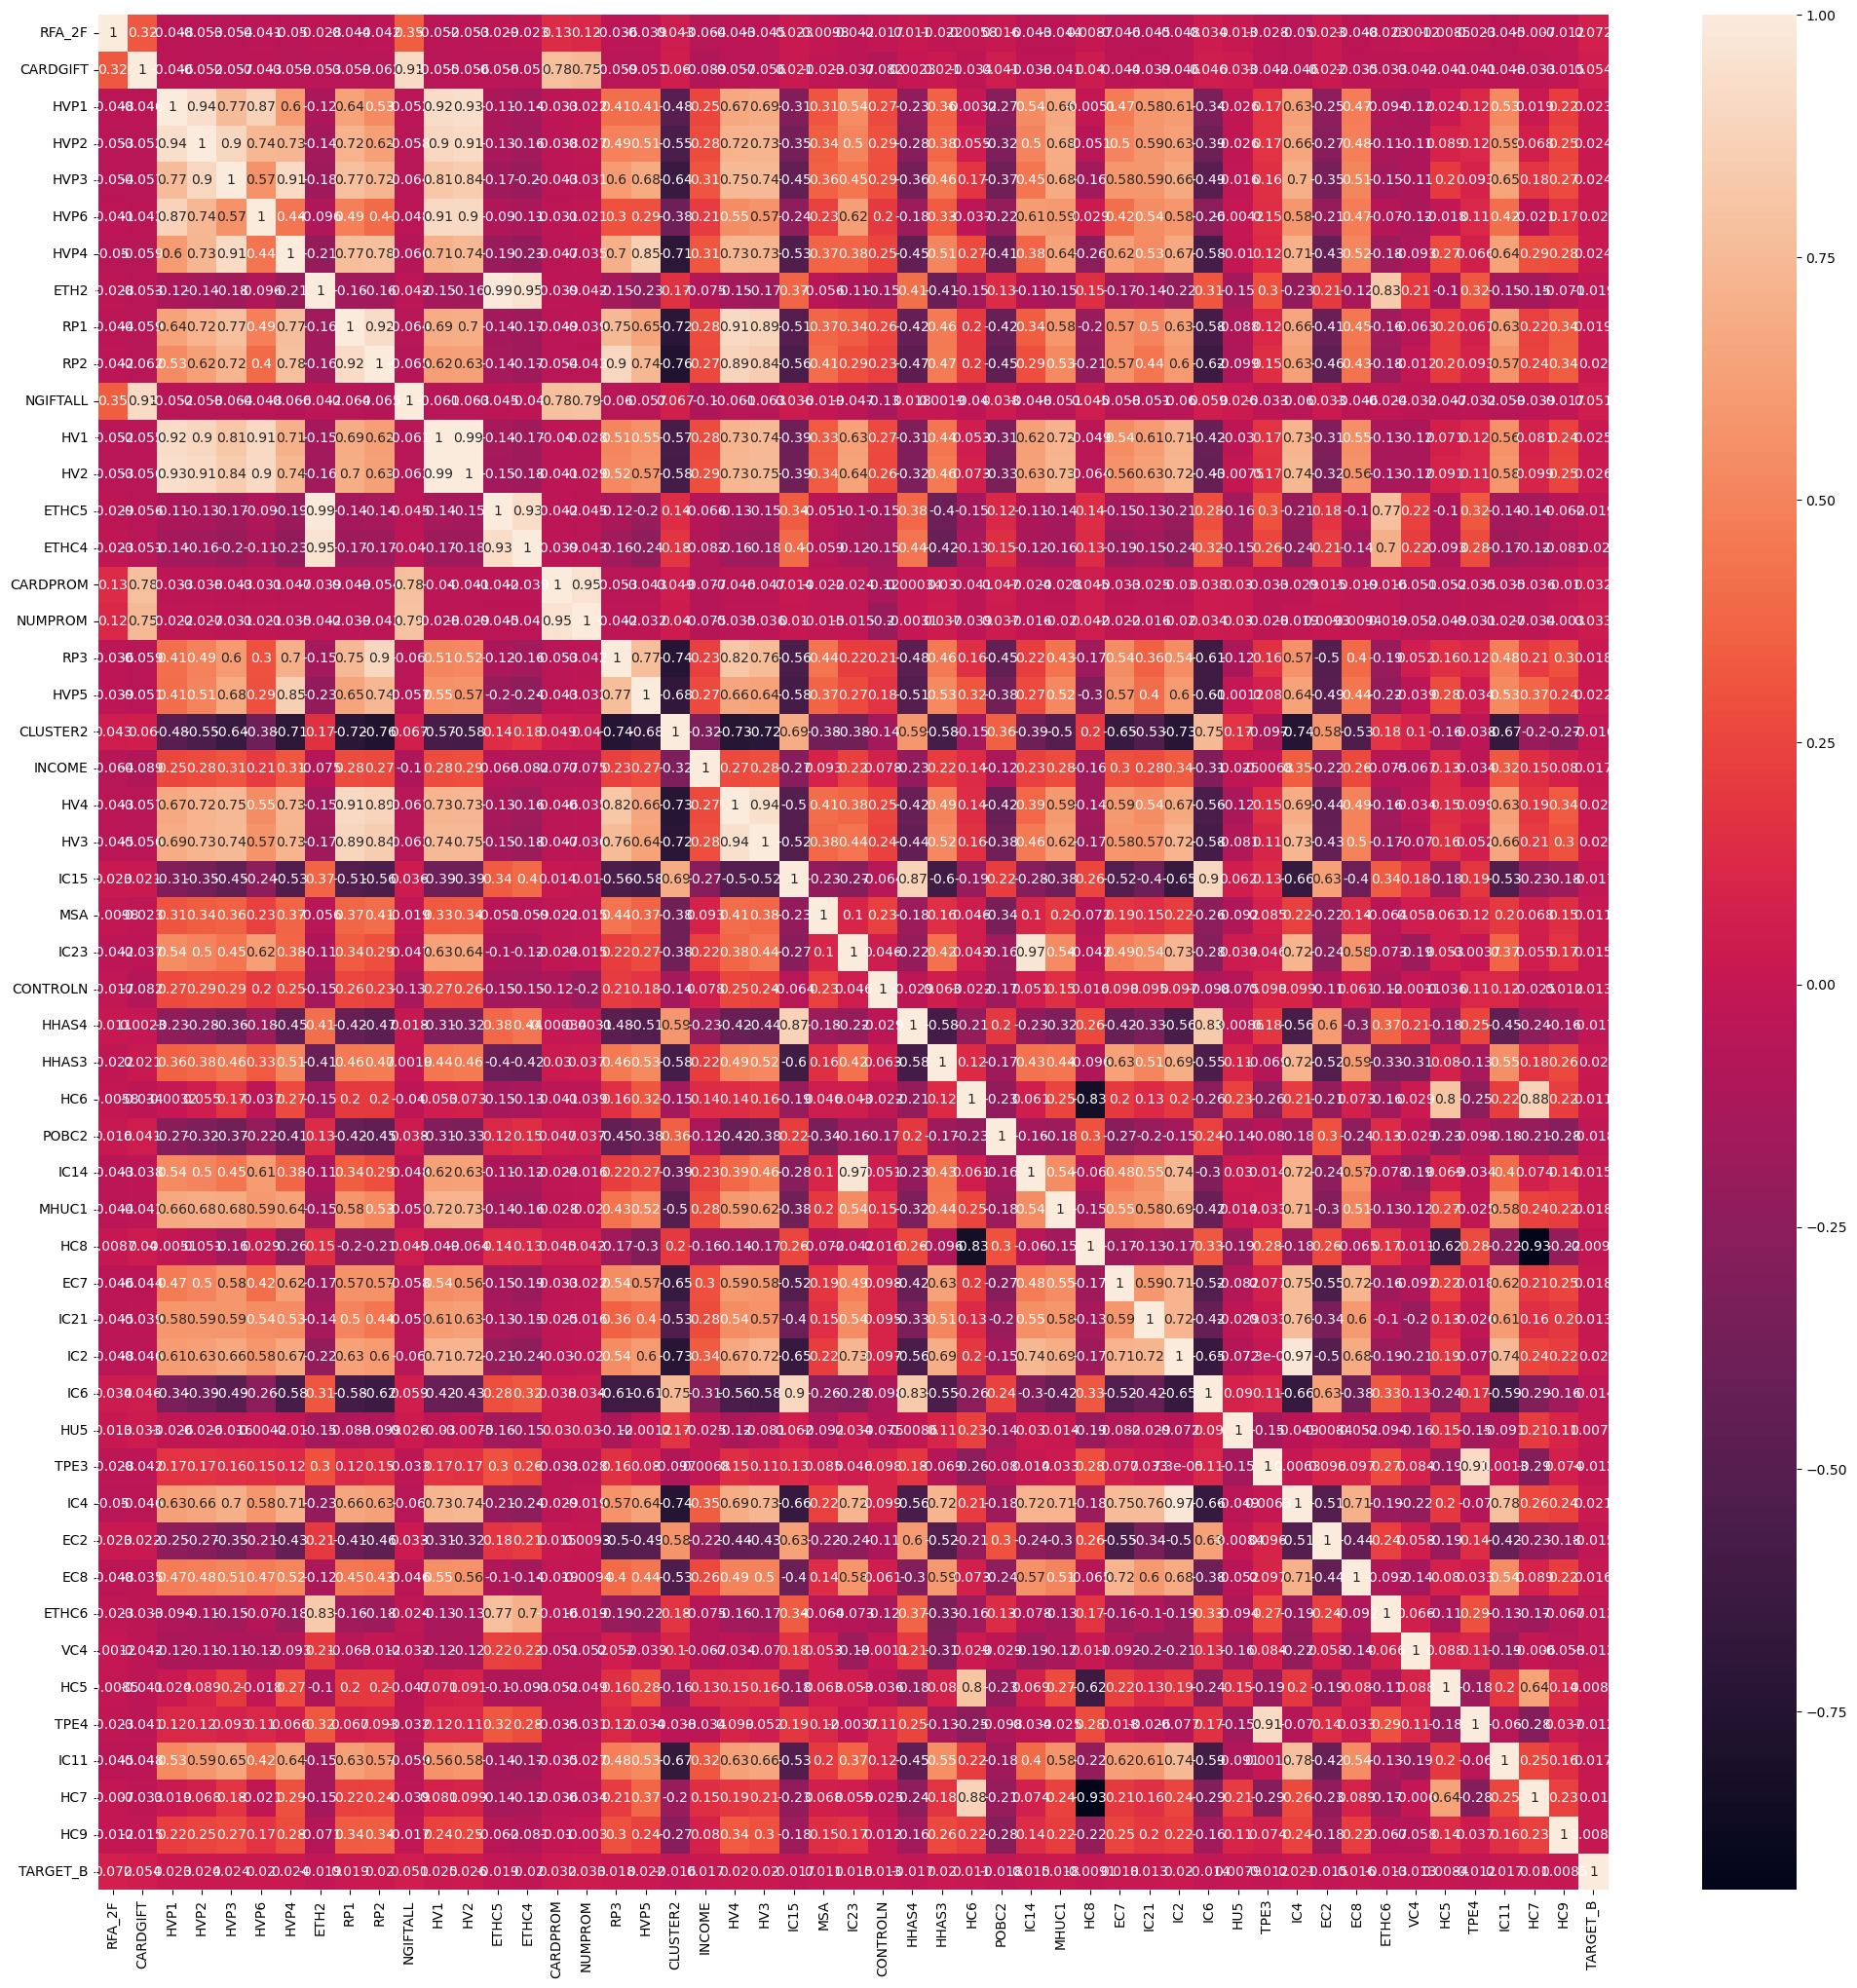

In [32]:
corr_matrix=numerical_data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [33]:
donation_best = corr.sort_values(by = 'TARGET_B', ascending=False)

donation_best['TARGET_B']

TARGET_B    1.000000
RFA_2F      0.072311
CARDGIFT    0.054027
NGIFTALL    0.050896
NUMPROM     0.033161
CARDPROM    0.032467
HV2         0.025607
HV1         0.025012
HVP4        0.024186
HVP3        0.024175
HVP2        0.023514
HVP1        0.022948
HVP5        0.022034
IC4         0.020535
HHAS3       0.020252
HV3         0.020191
HV4         0.020085
RP2         0.019928
HVP6        0.019869
IC2         0.019828
RP1         0.019158
MHUC1       0.018195
RP3         0.017939
EC7         0.017818
IC11        0.016961
INCOME      0.016508
EC8         0.016443
IC14        0.014884
IC23        0.014821
IC21        0.013339
CONTROLN    0.013165
MSA         0.011018
HC6         0.010803
HC7         0.010363
HC9         0.008515
HC5         0.008399
HU5         0.007898
HC8        -0.009124
TPE3       -0.012178
TPE4       -0.012396
VC4        -0.013304
ETHC6      -0.013369
IC6        -0.014362
EC2        -0.015423
CLUSTER2   -0.016390
IC15       -0.017081
HHAS4      -0.017448
POBC2      -0

For similarly named columns, I will keep only the column with the highest correlation score.
Based on the colinearity score with Target_B, I will keep:
- RFA_2F      
- CARDGIFT    
- NGIFTALL    
- NUMPROM     
- CARDPROM
- HV2
- HVP4
- IC4
- HHAS3
- RP2
- MHUC1
- EC7
- INCOME
- CONTROLN
- MSA
- HC6
- HC8
- TPE3
- VC4
- ETHC4
- CLUSTER2
- HHAS4
- POBC2
- ETH2
- IC15

In [34]:
cols_to_keep = ['RFA_2F', 'CARDGIFT', 'NGIFTALL','NUMPROM','CARDPROM','HV2','HVP4','IC4','HHAS3','RP2','MHUC1','EC7',
               'INCOME','CONTROLN','MSA','HC6','HC8','TPE3','VC4','ETHC4','CLUSTER2','HHAS4','POBC2','ETH2','IC15']

Now that the columns that need to be kept are decided, I will scale the data using the transformer that was created earlier. Then I will take only the columns that I have decided to keep in another data frame

In [35]:
numerical_scaled_df = transformer.transform(numerical)
numerical_scaled_df = pd.DataFrame(numerical_scaled_df, columns = numerical.columns)

In [36]:
numerical_scaled_feature = numerical_scaled_df[cols_to_keep]
numerical_scaled_feature.head()

RFA_2F  CARDGIFT  NGIFTALL   NUMPROM  CARDPROM       HV2      HVP4  \
0  1.000000  0.341463  0.127119  0.366492  0.433333  0.105833  0.272727   
1  0.333333  0.024390  0.008475  0.146597  0.183333  0.869667  0.989899   
2  1.000000  0.341463  0.110169  0.308901  0.416667  0.091000  0.181818   
3  1.000000  0.170732  0.063559  0.324607  0.433333  0.210500  0.696970   
4  0.333333  0.195122  0.152542  0.570681  0.700000  0.099000  0.161616   

        IC4     HHAS3       RP2     MHUC1       EC7    INCOME  CONTROLN  \
0  0.252000  0.515152  0.050505  0.285714  0.040404  0.666667  0.498045   
1  0.691333  0.666667  0.919192  0.952381  0.303030  0.833333  0.774510   
2  0.226667  0.313131  0.020202  0.428571  0.050505  0.333333  0.078617   
3  0.282000  0.262626  0.080808  0.761905  0.030303  0.000000  0.899764   
4  0.214000  0.111111  0.585859  0.285714  0.121212  0.333333  0.037079   

        MSA       HC6       HC8      TPE3       VC4     ETHC4  CLUSTER2  \
0  0.000000  0.313131  0.464646  0.000000  0.161616  0.000000  0.622951   
1  0.478632  0.979798  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.505051  0.313131  0.000000  0.080808  0.000000  0.967213   
3  0.997863  0.393939  0.555556  0.000000  0.161616  0.000000  0.655738   
4  0.534188  0.060606  0.676768  0.010101  0.202020  0.488372  0.409836   

      HHAS4     POBC2      ETH2      IC15  
0  0.010101  0.747475  0.010101  0.040404  
1  0.030303  0.393939  0.000000  0.020202  
2  0.111111  0.848485  0.020202  0.202020  
3  0.202020  0.676768  0.000000  0.353535  
4  0.141414  0.656566  0.989899  0.212121

In [37]:
categorical.head()
# The categorical columns seem alright, so I will keep them as is

STATE  CLUSTER HOMEOWNR GENDER  DATASRCE RFA_2R RFA_2A GEOCODE2 DOMAIN_A  \
0    IL       36        H      F         3      L      E        C        T   
1    CA       14        H      M         3      L      G        A        S   
2    NC       43        U      M         3      L      E        C        R   
3    CA       44        U      F         3      L      E        C        R   
4    FL       16        H      F         3      L      F        A        S   

   DOMAIN_B  ODATEW_YR  ODATEW_MM  DOB_YR  DOB_MM  MINRDATE_YR  MINRDATE_MM  \
0         2         89          1      37      12           92            8   
1         1         94          1      52       2           93           10   
2         2         90          1       0       2           91           11   
3         2         87          1      28       1           87           11   
4         2         86          1      20       1           93           10   

   MAXRDATE_YR  MAXRDATE_MM  LASTDATE_YR  LASTDATE_MM  FIRSTDATE_YR  \
0           94            2           95           12            89   
1           95           12           95           12            93   
2           92            7           95           12            90   
3           94           11           95           12            87   
4           96            1           96            1            79   

   FIRSTDATE_MM  
0            11  
1            10  
2             1  
3             2  
4             3

In [38]:
print(numerical_scaled_feature.shape)
print(categorical.shape)

(95412, 25)
(95412, 22)


#### Now that I have the numerical columns with feature selected, I will concatenate with categorical and then train/test split and classify

In [39]:
# data_feature = pd.concat([numerical_after, categorical,targets['TARGET_B']], axis=1)
y_feature = targets['TARGET_B']
# X_feature = data_feature.drop(['TARGET_B'], axis = 1)

In order to train the model again, I will use the oversampled data, keep only the columns I want from feature selection and create a new dataframe.

In [40]:
new_train_data_oversampled=pd.concat([train_oversampled[cols_to_keep],train_oversampled[encoded_categorical_train.columns]], axis=1 )

In [41]:
new_train_data_oversampled.head()

RFA_2F  CARDGIFT  NGIFTALL   NUMPROM  CARDPROM       HV2      HVP4  \
0  0.666667  0.195122  0.063559  0.230366  0.366667  0.107333  0.232323   
1  0.000000  0.024390  0.000000  0.052356  0.083333  0.052667  0.040404   
3  0.000000  0.170732  0.033898  0.314136  0.433333  0.340333  1.000000   
4  0.000000  0.024390  0.008475  0.141361  0.183333  0.100167  0.070707   
5  0.333333  0.317073  0.114407  0.361257  0.466667  0.102167  0.171717   

        IC4     HHAS3       RP2     MHUC1       EC7    INCOME  CONTROLN  \
0  0.228667  0.575758  0.080808  0.285714  0.252525  0.500000  0.127215   
1  0.166000  0.252525  0.010101  0.380952  0.030303  0.666667  0.599688   
3  0.350667  0.575758  0.919192  0.428571  0.090909  0.833333  0.863723   
4  0.182667  0.434343  0.161616  0.285714  0.141414  0.666667  0.555564   
5  0.247333  0.505051  0.121212  0.285714  0.050505  0.500000  0.518454   

        MSA       HC6       HC8      TPE3       VC4     ETHC4  CLUSTER2  \
0  0.337607  0.141414  0.545455  0.000000  0.000000  0.162791  0.508197   
1  0.000000  0.454545  0.414141  0.000000  0.101010  0.093023  0.967213   
3  0.616987  0.010101  0.868687  0.040404  0.070707  0.023256  0.131148   
4  0.632479  0.797980  0.090909  0.000000  0.545455  0.069767  0.573770   
5  0.752137  0.050505  0.878788  0.000000  0.101010  0.000000  0.836066   

      HHAS4     POBC2      ETH2      IC15  STATE_FL  STATE_GA  STATE_IL  \
0  0.070707  0.676768  0.212121  0.080808       0.0       0.0       0.0   
1  0.232323  0.808081  0.161616  0.363636       0.0       0.0       0.0   
3  0.020202  0.545455  0.010101  0.010101       0.0       0.0       0.0   
4  0.151515  0.393939  0.080808  0.212121       0.0       0.0       0.0   
5  0.111111  0.818182  0.000000  0.111111       0.0       0.0       0.0   

   STATE_IN  STATE_MI  STATE_MO  STATE_NC  STATE_TX  STATE_WA  STATE_WI  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5       0.0       0.0       1.0       0.0       0.0       0.0       0.0   

   STATE_other  CLUSTER_2  CLUSTER_3  CLUSTER_4  CLUSTER_5  CLUSTER_6  \
0          1.0        0.0        0.0        0.0        0.0        0.0   
1          1.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        1.0        0.0   
4          1.0        0.0        0.0        0.0        0.0        0.0   
5          0.0        0.0        0.0        0.0        0.0        0.0   

   CLUSTER_7  CLUSTER_8  CLUSTER_9  CLUSTER_10  CLUSTER_11  CLUSTER_12  \
0        0.0        0.0        0.0         0.0         0.0         0.0   
1        0.0        0.0        0.0         0.0         0.0         0.0   
3        0.0        0.0        0.0         0.0         0.0         0.0   
4        0.0        0.0        0.0         0.0         0.0         0.0   
5        0.0        0.0        0.0         0.0         0.0         0.0   

   CLUSTER_13  CLUSTER_14  CLUSTER_15  CLUSTER_16  CLUSTER_17  CLUSTER_18  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   
5         0.0         0.0         0.0         0.0         0.0         0.0   

   CLUSTER_19  CLUSTER_20  CLUSTER_21  CLUSTER_22  CLUSTER_23  CLUSTER_24  \
0         0.0         0.0         0.0         0.0         0.0         1.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   
5         0.0     

In [42]:
X_feature_numerical = numerical_scaled_feature
X_feature_categorical = categorical

In [43]:
# Now to encode the categorical data

In [44]:
#encoder = OneHotEncoder(handle_unknown = 'ignore',drop='first').fit(X_feature_categorical)
encoded_categorical_feature = encoder.transform(X_feature_categorical).toarray()
encoded_categorical_feature = pd.DataFrame(encoded_categorical_feature, columns=encoder.get_feature_names_out()) # needed to avoid error

/Users/vidhya/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
X_treated_feature = pd.concat([X_feature_numerical,encoded_categorical_feature], axis=1)
X_treated_feature = X_treated_feature.reset_index(drop=True)

In [46]:
X_treated_feature.head()

RFA_2F  CARDGIFT  NGIFTALL   NUMPROM  CARDPROM       HV2      HVP4  \
0  1.000000  0.341463  0.127119  0.366492  0.433333  0.105833  0.272727   
1  0.333333  0.024390  0.008475  0.146597  0.183333  0.869667  0.989899   
2  1.000000  0.341463  0.110169  0.308901  0.416667  0.091000  0.181818   
3  1.000000  0.170732  0.063559  0.324607  0.433333  0.210500  0.696970   
4  0.333333  0.195122  0.152542  0.570681  0.700000  0.099000  0.161616   

        IC4     HHAS3       RP2     MHUC1       EC7    INCOME  CONTROLN  \
0  0.252000  0.515152  0.050505  0.285714  0.040404  0.666667  0.498045   
1  0.691333  0.666667  0.919192  0.952381  0.303030  0.833333  0.774510   
2  0.226667  0.313131  0.020202  0.428571  0.050505  0.333333  0.078617   
3  0.282000  0.262626  0.080808  0.761905  0.030303  0.000000  0.899764   
4  0.214000  0.111111  0.585859  0.285714  0.121212  0.333333  0.037079   

        MSA       HC6       HC8      TPE3       VC4     ETHC4  CLUSTER2  \
0  0.000000  0.313131  0.464646  0.000000  0.161616  0.000000  0.622951   
1  0.478632  0.979798  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.505051  0.313131  0.000000  0.080808  0.000000  0.967213   
3  0.997863  0.393939  0.555556  0.000000  0.161616  0.000000  0.655738   
4  0.534188  0.060606  0.676768  0.010101  0.202020  0.488372  0.409836   

      HHAS4     POBC2      ETH2      IC15  STATE_FL  STATE_GA  STATE_IL  \
0  0.010101  0.747475  0.010101  0.040404       0.0       0.0       1.0   
1  0.030303  0.393939  0.000000  0.020202       0.0       0.0       0.0   
2  0.111111  0.848485  0.020202  0.202020       0.0       0.0       0.0   
3  0.202020  0.676768  0.000000  0.353535       0.0       0.0       0.0   
4  0.141414  0.656566  0.989899  0.212121       1.0       0.0       0.0   

   STATE_IN  STATE_MI  STATE_MO  STATE_NC  STATE_TX  STATE_WA  STATE_WI  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   STATE_other  CLUSTER_2  CLUSTER_3  CLUSTER_4  CLUSTER_5  CLUSTER_6  \
0          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
2          0.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        0.0        0.0   
4          0.0        0.0        0.0        0.0        0.0        0.0   

   CLUSTER_7  CLUSTER_8  CLUSTER_9  CLUSTER_10  CLUSTER_11  CLUSTER_12  \
0        0.0        0.0        0.0         0.0         0.0         0.0   
1        0.0        0.0        0.0         0.0         0.0         0.0   
2        0.0        0.0        0.0         0.0         0.0         0.0   
3        0.0        0.0        0.0         0.0         0.0         0.0   
4        0.0        0.0        0.0         0.0         0.0         0.0   

   CLUSTER_13  CLUSTER_14  CLUSTER_15  CLUSTER_16  CLUSTER_17  CLUSTER_18  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         1.0         0.0         0.0   

   CLUSTER_19  CLUSTER_20  CLUSTER_21  CLUSTER_22  CLUSTER_23  CLUSTER_24  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0     

In [47]:
# Training the random forest classifier with the modified over sampled data and then predicting for all of the 
# scaled and encoded data

In [48]:
clf_new = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf_new.fit(new_train_data_oversampled, y_train_over)
y_pred_feature = clf_new.predict(X_treated_feature)
print('Training Score',clf_new.score(new_train_data_oversampled, y_train_over))
print('Testing Score',clf_new.score(X_treated_feature, y_feature))
display(confusion_matrix(y_feature, y_pred_feature))

#display(y_test.value_counts()

Training Score 0.6096418618767762
Testing Score 0.5503395799270532


array([[49346, 41223],
       [ 1680,  3163]])

In [49]:
y_pred_df = pd.DataFrame(y_pred_feature, columns = ['Prediction'])
print(X_treated_feature.shape)
#print(y_pred_df.tail())
X_treated_feature.tail()



(95412, 341)


RFA_2F  CARDGIFT  NGIFTALL   NUMPROM  CARDPROM       HV2      HVP4  \
95407  0.000000  0.000000  0.000000  0.052356  0.083333  0.170833  0.737374   
95408  0.000000  0.000000  0.000000  0.031414  0.050000  0.287167  0.919192   
95409  0.666667  0.097561  0.025424  0.151832  0.216667  0.062833  0.010101   
95410  1.000000  0.439024  0.169492  0.643979  0.583333  0.409833  1.000000   
95411  0.000000  0.268293  0.161017  0.706806  0.516667  0.174833  0.757576   

            IC4     HHAS3       RP2     MHUC1       EC7    INCOME  CONTROLN  \
95407  0.356667  0.707071  0.848485  0.761905  0.151515  0.666667  0.962399   
95408  0.566000  0.616162  0.262626  0.857143  0.363636  1.000000  0.639828   
95409  0.230000  0.262626  0.343434  0.238095  0.111111  0.666667  0.988852   
95410  0.370667  0.464646  0.888889  0.571429  0.151515  1.000000  0.024466   
95411  0.346000  0.545455  0.656566  0.380952  0.282828  0.666667  0.965246   

            MSA       HC6       HC8      TPE3       VC4     ETHC4  CLUSTER2  \
95407  0.040598  0.787879  0.090909  0.020202  0.252525  0.069767  0.180328   
95408  0.358974  0.949495  0.060606  0.040404  0.151515  0.046512  0.016393   
95409  0.431624  0.000000  1.000000  0.000000  0.202020  0.162791  0.540984   
95410  0.933226  0.171717  0.010101  0.000000  0.080808  0.000000  0.163934   
95411  0.982906  0.868687  0.010101  0.010101  0.151515  0.069767  0.180328   

          HHAS4     POBC2      ETH2      IC15  STATE_FL  STATE_GA  STATE_IL  \
95407  0.060606  0.262626  0.101010  0.090909       0.0       0.0       0.0   
95408  0.070707  0.515152  0.030303  0.101010       0.0       0.0       0.0   
95409  0.262626  0.828283  0.141414  0.262626       0.0       0.0       0.0   
95410  0.030303  0.505051  0.010101  0.040404       0.0       0.0       0.0   
95411  0.030303  0.484848  0.121212  0.020202       0.0       0.0       0.0   

       STATE_IN  STATE_MI  STATE_MO  STATE_NC  STATE_TX  STATE_WA  STATE_WI  \
95407       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
95408       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
95409       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
95410       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
95411       0.0       0.0       0.0       1.0       0.0       0.0       0.0   

       STATE_other  CLUSTER_2  CLUSTER_3  CLUSTER_4  CLUSTER_5  CLUSTER_6  \
95407          1.0        0.0        0.0        0.0        0.0        0.0   
95408          0.0        0.0        0.0        0.0        0.0        0.0   
95409          0.0        0.0        0.0        0.0        0.0        0.0   
95410          0.0        0.0        0.0        0.0        0.0        0.0   
95411          0.0        0.0        0.0        0.0        0.0        0.0   

       CLUSTER_7  CLUSTER_8  CLUSTER_9  CLUSTER_10  CLUSTER_11  CLUSTER_12  \
95407        0.0        0.0        0.0         0.0         0.0         0.0   
95408        0.0        0.0        0.0         0.0         0.0         0.0   
95409        0.0        0.0        0.0         0.0         0.0         0.0   
95410        0.0        0.0        0.0         0.0         0.0         0.0   
95411        0.0        0.0        0.0         0.0         0.0         0.0   

       CLUSTER_13  CLUSTER_14  CLUSTER_15  CLUSTER_16  CLUSTER_17  CLUSTER_18  \
95407         0.0         0.0         0.0         0.0         0.0         0.0   
95408         0.0         0.0         0.0         0.0         0.0         0.0   
95409         0.0         0.0         0.0         0.0         0.0         0.0   
95410         0.0         0.0         0.0         0.0         0.0         0.0   
95411         0.0         0.0         0.0         0.0         0.0         0.0   

       CLUSTER_19  CLUSTER_20  CLUSTER_21  CLUSTER_22  CLUSTER_23  CLUSTER_24  \
95407         0.0         0.0         0.0         0.0         0.0         0.0   
95408         0.0         0.0         0.0         0.0

In [50]:
#Creating a dataframe with the original data and adding the predicted TARGET_B.

new_df = pd.concat([numerical,categorical, y_pred_df], axis=1)
new_df.shape


(95412, 338)

## Process 2 - Regression Model to Predict the Donation Amount

In [51]:
#Loading data from the csv
numerical2 = pd.read_csv('numerical.csv')
categorical2 = pd.read_csv('categorical.csv')
targets2 = pd.read_csv('target.csv')
data2 = pd.concat([numerical2, categorical2, targets2], axis = 1)
#data2['TARGET_D'].value_counts()

In [52]:
donor_data = data2[data2['TARGET_B'] == 1]
donor_data.shape

(4843, 339)

#### Feature Selection

In [53]:
#Initializing scaler.
scaler = MinMaxScaler()
numerical_data = donor_data[numerical2.columns]
numerical_data_scaled = scaler.fit_transform(numerical_data)
numerical_data_scaled.shape

(4843, 315)

In [54]:
#Using RFE for feature selection as k-best should be used only for classification and not regression.
X_reg = numerical_data_scaled
y_reg = donor_data['TARGET_D']


from sklearn.feature_selection import RFE # Recursive Feature Elimination
from sklearn import linear_model
lm = linear_model.LinearRegression()
rfe = RFE(lm, n_features_to_select=25, verbose=False)
rfe.fit(X_reg, y_reg)

RFE(estimator=LinearRegression(), n_features_to_select=25, verbose=False)

In [55]:
rfe.ranking_

array([162, 200, 277, 265,  76,  80, 289, 229, 125, 124, 225,  79, 291,
        20, 102,  21,   1,   1,   1,  23,  22,   1,  50, 104, 105,   1,
       106, 255, 185,  46, 227,  62, 256,   1,   1,   1,   1,  77,  48,
        49,  47,  31, 166, 174, 114, 252, 121, 116, 117,  72, 267, 266,
       268,  34, 113, 115, 192, 112, 264,  41,  81,  42, 175,   4,   6,
        40,  39,  38,  26,  25,  27,  24, 107, 181,  17, 285, 177,  16,
       109, 110,  14,  15,  13, 204, 248, 201, 287,   1,   1, 206, 207,
       217,   1,   5,   1,   1,  32,  33,   1,  89,  88,   2,   3,   7,
         1,   1,   1,  66,  51,  52, 275, 208, 242, 241, 240, 249,  57,
        85, 205,  84, 260, 191, 111, 193,  18,   8,  10,   9,  11, 203,
       202, 176, 215, 281, 224,  82,  35,  73,  90,  99,  28,  94,  96,
        95,  97,  91, 198,  92, 280,  29, 151, 236, 171,  93, 100,  98,
       262, 155,  30, 149, 230, 210, 150,   1,   1, 219, 136, 152, 222,
       220, 221, 223, 103, 153, 135, 273, 279, 269, 126, 127, 17

In [56]:
# After we run the algorithm, it labels the top features as 1 and the rest are marked in an decreasing order of importance.
df_reg = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df_reg['Column_name'] = numerical2.columns
df_reg

print(df_reg.sort_values(by = ['Rank'], ascending = True).head(50))

     Rank Column_name
92      1        HHD1
21      1        ETH1
25      1        ETH5
303     1    RAMNTALL
33      1       ETH13
34      1       ETH14
35      1       ETH15
18      1     POP90C3
36      1       ETH16
106     1       ETHC3
105     1       ETHC2
104     1       ETHC1
98      1        HHD7
95      1        HHD4
94      1        HHD3
88      1         HU2
17      1     POP90C2
87      1         HU1
308     1    LASTGIFT
163     1         MC1
306     1    MINRAMNT
16      1     POP90C1
164     1         MC2
310     1     AVGGIFT
304     1    NGIFTALL
101     2       HHD10
102     3       HHD11
63      4        HHN2
93      5        HHD2
64      6        HHN3
103     7       HHD12
125     8       HUPA4
127     9       HUPA6
126    10       HUPA5
128    11       HUPA7
307    12    MAXRAMNT
82     13         DW9
80     14         DW7
81     15         DW8
77     16         DW4
74     17         DW1
124    18       HUPA3
293    19        HC20
13     20      POP901
15     21 

In [57]:
cols_reg = df_reg.sort_values(by = ['Rank'], ascending = True).head(50)
cols_reg

Rank Column_name
92      1        HHD1
21      1        ETH1
25      1        ETH5
303     1    RAMNTALL
33      1       ETH13
34      1       ETH14
35      1       ETH15
18      1     POP90C3
36      1       ETH16
106     1       ETHC3
105     1       ETHC2
104     1       ETHC1
98      1        HHD7
95      1        HHD4
94      1        HHD3
88      1         HU2
17      1     POP90C2
87      1         HU1
308     1    LASTGIFT
163     1         MC1
306     1    MINRAMNT
16      1     POP90C1
164     1         MC2
310     1     AVGGIFT
304     1    NGIFTALL
101     2       HHD10
102     3       HHD11
63      4        HHN2
93      5        HHD2
64      6        HHN3
103     7       HHD12
125     8       HUPA4
127     9       HUPA6
126    10       HUPA5
128    11       HUPA7
307    12    MAXRAMNT
82     13         DW9
80     14         DW7
81     15         DW8
77     16         DW4
74     17         DW1
124    18       HUPA3
293    19        HC20
13     20      POP901
15     21      POP903
20     22     POP90C5
19     23     POP90C4
71     24       MARR4
69     25       MARR2
68     26       MARR1

In [58]:
cols_reg_list = cols_reg['Column_name'].tolist()


In [59]:
numerical_data_reg = pd.concat([donor_data[cols_reg_list], donor_data['TARGET_D']], axis=1)
# corr = numerical_data_reg.corr()
# corr

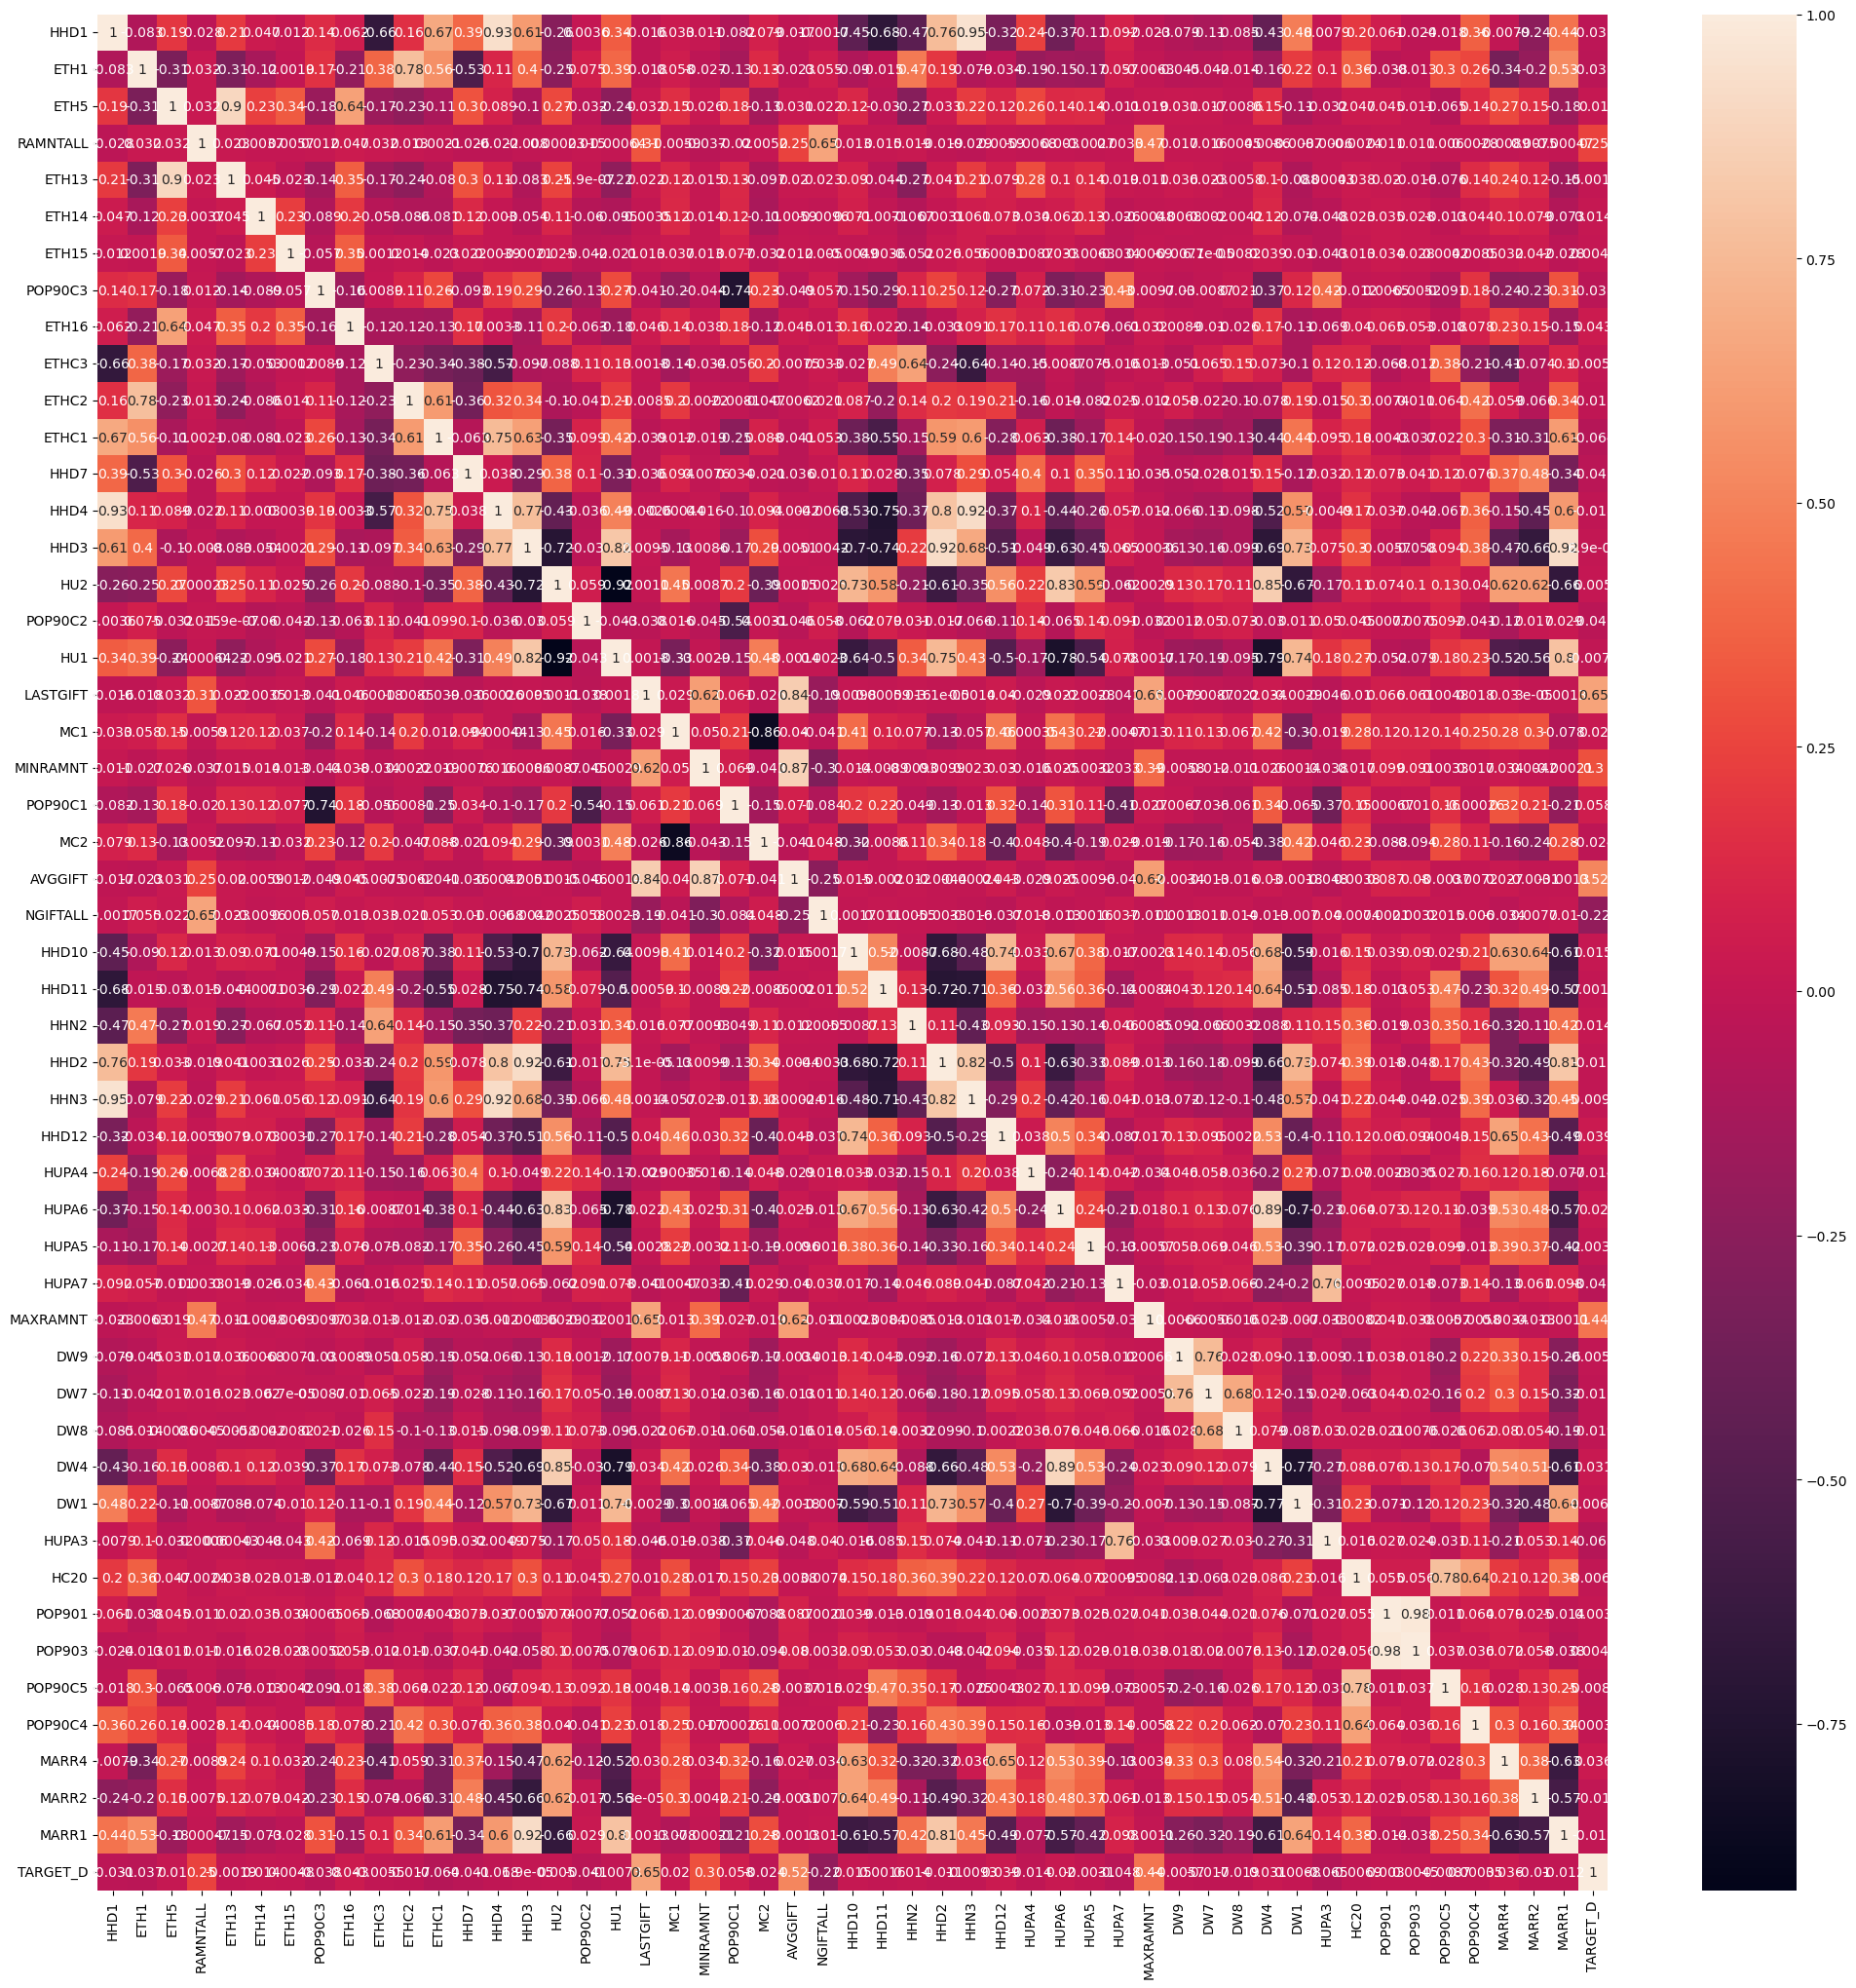

In [60]:
corr_matrix_reg=numerical_data_reg.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(corr_matrix_reg, annot=True)
plt.show()

In [61]:
donation_reg = corr_matrix_reg.sort_values(by = 'TARGET_D', ascending=False)

donation_reg['TARGET_D']

TARGET_D    1.000000
LASTGIFT    0.645388
AVGGIFT     0.516725
MAXRAMNT    0.443145
MINRAMNT    0.295783
RAMNTALL    0.247667
POP90C1     0.057889
ETH16       0.042855
HHD12       0.038829
MARR4       0.036019
DW4         0.031050
HUPA6       0.020345
MC1         0.019567
HHD10       0.015415
HHN2        0.014186
ETH14       0.013957
ETH5        0.010197
DW1         0.006830
HU2         0.004982
ETH15       0.004757
POP903      0.004506
POP901      0.003010
HHD11       0.001640
POP90C4     0.000345
HHD3        0.000069
ETH13      -0.001931
HUPA5      -0.003081
ETHC3      -0.005478
DW9        -0.005660
HC20       -0.006912
HU1        -0.007265
POP90C5    -0.008680
HHN3       -0.009291
MARR2      -0.010145
HHD2       -0.010732
MARR1      -0.011559
HUPA4      -0.013694
DW7        -0.016695
ETHC2      -0.016719
HHD4       -0.017821
DW8        -0.019015
MC2        -0.023792
HHD1       -0.030764
ETH1       -0.036507
POP90C3    -0.038204
POP90C2    -0.041051
HHD7       -0.041387
HUPA7      -0

In [62]:
reg_cols_to_keep = ['LASTGIFT','AVGGIFT','MAXRAMNT','MINRAMNT','RAMNTALL','POP90C1','ETH16','HHD12','MARR4','DW4',
                    'HUPA6','MC1','HHN2','HU2','DW9','HC20','HU1','ETHC1','HUPA3','NGIFTALL']

In [63]:
# columns to drop is the all columns minus the columns I have decided to keep
columns_to_drop = list(set(numerical_data.columns) - set(reg_cols_to_keep))

In [64]:
#columns_to_drop

In [65]:
donor_data_feature = donor_data.drop(columns_to_drop, axis=1)

In [66]:
# This dataframe has only the columns that has been feature selected.
donor_data_feature.shape

(4843, 44)

In [92]:
donor_data_feature.columns

Index(['POP90C1', 'ETH16', 'HHN2', 'MARR4', 'DW4', 'DW9', 'HU1', 'HU2',
       'HHD12', 'ETHC1', 'HUPA3', 'HUPA6', 'MC1', 'HC20', 'RAMNTALL',
       'NGIFTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT', 'STATE',
       'CLUSTER', 'HOMEOWNR', 'GENDER', 'DATASRCE', 'RFA_2R', 'RFA_2A',
       'GEOCODE2', 'DOMAIN_A', 'DOMAIN_B', 'ODATEW_YR', 'ODATEW_MM', 'DOB_YR',
       'DOB_MM', 'MINRDATE_YR', 'MINRDATE_MM', 'MAXRDATE_YR', 'MAXRDATE_MM',
       'LASTDATE_YR', 'LASTDATE_MM', 'FIRSTDATE_YR', 'FIRSTDATE_MM',
       'TARGET_B', 'TARGET_D'],
      dtype='object')

### Train-Test Split

In [94]:
X_reg = donor_data_feature.drop(['TARGET_D', 'TARGET_B'], axis=1)
y_reg = donor_data_feature['TARGET_D']

In [95]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [96]:
numericalX_train_reg = X_train_reg[reg_cols_to_keep] 
numericalX_test_reg = X_test_reg[reg_cols_to_keep] 
categoricalX_train_reg = X_train_reg[categorical2.columns] 
categoricalX_test_reg  = X_test_reg[categorical2.columns] 

In [97]:
print(numericalX_train_reg.shape)
print(numericalX_test_reg.shape)
print(categoricalX_train_reg.shape)
print(categoricalX_test_reg.shape)

(3874, 20)
(969, 20)
(3874, 22)
(969, 22)


In [98]:
# we scale the numericals so we can use the same dataset to perform a regression later.

from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(numericalX_train_reg)
scaled_numerical_train_reg = transformer.transform(numericalX_train_reg)
scaled_numerical_train_reg = pd.DataFrame(scaled_numerical_train_reg, columns=numericalX_train_reg.columns)
scaled_numerical_test_reg = transformer.transform(numericalX_test_reg)
scaled_numerical_test_reg  = pd.DataFrame(scaled_numerical_test_reg, columns=numericalX_train_reg.columns)

In [99]:
# we OneHotEncode the categoricals so we can use the same dataset to perform a regression later (in the lab).

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore', drop='first').fit(categoricalX_train_reg)
encoded_categorical_train_reg = encoder.transform(categoricalX_train_reg).toarray()
encoded_categorical_train_reg = pd.DataFrame(encoded_categorical_train_reg, columns=encoder.get_feature_names_out()) # needed to avoid error
encoded_categorical_test_reg = encoder.transform(categoricalX_test_reg).toarray()
encoded_categorical_test_reg = pd.DataFrame(encoded_categorical_test_reg, columns=encoder.get_feature_names_out())

In [100]:
X_train_treated_reg = pd.concat([scaled_numerical_train_reg, encoded_categorical_train_reg], axis = 1)
X_test_treated_reg  = pd.concat([scaled_numerical_test_reg,  encoded_categorical_test_reg],  axis = 1)

In [101]:
#reset y_train, y_test index because when encoding is done, the index will be reset
y_train_reg = y_train_reg.reset_index(drop=True)
y_test_reg = y_test_reg.reset_index(drop=True)

In [102]:
#complete the code here
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

linreg_model = LinearRegression()
forest_model   = RandomForestRegressor()

import numpy as np
model_pipeline = [linreg_model, forest_model]
model_names = ['Linear Regression', 'Random Forest Regressor']

for model, model_name in zip(model_pipeline, model_names):
    model.fit(X_train_treated_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_treated_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    print(f'{model}: Mean Squared Error: {mse}')

LinearRegression(): Mean Squared Error: 61.19719582380958
RandomForestRegressor(): Mean Squared Error: 75.32884440652218


LinearRegression(): Mean Squared Error: 61.19719582380958
RandomForestRegressor(): Mean Squared Error: 76.45246072086687

Based on the score above, I think the Random Forest Regressor performs better compared to LinearRegression. I will use Random Forest Regressor to predict.

### Now load the data from Process 1:
- Take only the columns that match the feature selected columns
- Encode and Scale using the existing encoder and scaler
- Predict using the trained models.


In [103]:
new_df.head()

TCODE        AGE  INCOME  WEALTH1  HIT  MALEMILI  MALEVET  VIETVETS  \
0      0  60.000000       5        9    0         0       39        34   
1      1  46.000000       6        9   16         0       15        55   
2      1  61.611649       3        1    2         0       20        29   
3      0  70.000000       1        4    2         0       23        14   
4      0  78.000000       3        2   60         1       28         9   

   WWIIVETS  LOCALGOV  STATEGOV  FEDGOV  WEALTH2  POP901  POP902  POP903  \
0        18        10         2       1        5     992     264     332   
1        11         6         2       1        9    3611     940     998   
2        33         6         8       1        1    7001    2040    2669   
3        31         3         0       3        0     640     160     219   
4        53        26         3       2        9    2520     627     761   

   POP90C1  POP90C2  POP90C3  POP90C4  POP90C5  ETH1  ETH2  ETH3  ETH4  ETH5  \
0        0       35       65       47       53    92     1     0     0    11   
1       99        0        0       50       50    67     0     0    31     6   
2        0        2       98       49       51    96     2     0     0     2   
3        0        8       92       54       46    61     0     0    11    32   
4       99        0        0       46       54     2    98     0     0     1   

   ETH6  ETH7  ETH8  ETH9  ETH10  ETH11  ETH12  ETH13  ETH14  ETH15  ETH16  \
0     0     0     0     0      0      0      0     11      0      0      0   
1     4     2     6     4     14      0      0      2      0      1      4   
2     0     0     0     0      0      0      0      2      0      0      0   
3     6     2     0     0      0      0      0     31      0      0      1   
4     0     0     0     0      0      0      0      0      0      0      0   

   AGE901  AGE902  AGE903  AGE904  AGE905  AGE906  AGE907  CHIL1  CHIL2  \
0      39      48      51      40      50      54      25     31     42   
1      34      41      43      32      42      45      32     33     46   
2      35      43      46      37      45      49      23     35     40   
3      32      40      44      34      43      47      25     45     35   
4      33      45      50      36      46      50      27     34     43   

   CHIL3  AGEC1  AGEC2  AGEC3  AGEC4  AGEC5  AGEC6  AGEC7  CHILC1  CHILC2  \
0     27     11     14     18     17     13     11     15      12      11   
1     21     13     14     33     23     10      4      2      11      16   
2     25     13     20     19     16     13     10      8      15      14   
3     20     15     25     17     17     12      7      7      20      17   
4     23     14     21     13     15     20     12      5      13      15   

   CHILC3  CHILC4  CHILC5  HHAGE1  HHAGE2  HHAGE3  HHN1  HHN2  HHN3  HHN4  \
0      34      25      18      26      10      23    18    33    49    28   
1      36      22      15      12       1       5     4    21    75    55   
2      30      22      19      25      10      23    21    35    44    22   
3      30      14      19      25      11      23    23    27    50    30   
4      34      19      19      31       7      27    16    26    57    36   

   HHN5  HHN6  MARR1  MARR2  MARR3  MARR4  HHP1  HHP2  DW1  DW2  DW3  DW4  \
0    12     4     61      7     12     19   198   276   97   95    2    2   
1    23     9     69      4      3     24   317   360   99   99    0    0   
2     6     2     63      9      9     19   183   254   69   69    1    6   
3    15     8     63      9      6     23   199   283   85   83    3    4   
4    24    14     42     17      9     33   235   323   99   98    0    0   

   DW5  DW6  DW7  DW8  DW9   HV1   HV2  HV3  HV4  HU1  HU2  HU3  HU4  HU5  \
0    0    0    7    7    0   479   635    3    2   86   14   96    4    7   
1    0    0    0    0    0  5468  5218   12   10   96    4   97    3    9   
2    5    3    3    3    0   497   546    2    1   78   22   93    7   18   
3  

In [104]:
donor_data_feature.head()

POP90C1  ETH16  HHN2  MARR4  DW4  DW9  HU1  HU2  HHD12  ETHC1  HUPA3  \
20       99      0    30     22   10    0   88   12      5     21      0   
30       99      2    23     17    0    0   97    3      1     30      0   
45       89      0    43     16   28    0   96    4      2     16      0   
78       99      1    44     27   20    0   63   37     13     11      0   
93       99      0    21     34    0    0   89   11      2      0      0   

    HUPA6  MC1  HC20  RAMNTALL  NGIFTALL  MINRAMNT  MAXRAMNT  LASTGIFT  \
20      7   61    99      61.0        15       2.0       7.0       5.0   
30      0   74    99      68.0        11       2.0      10.0       7.0   
45      0   61    99     102.0        21       3.0       6.0       5.0   
78      6   55    99     132.0        12       5.0      17.0      10.0   
93      0   39    99      94.0        10       5.0      12.0      12.0   

      AVGGIFT  STATE  CLUSTER HOMEOWNR GENDER  DATASRCE RFA_2R RFA_2A  \
20   4.066667  other       12        H      F         3      L      D   
30   6.181818     TX       35        H      M         3      L      D   
45   4.857143  other       24        H      F         3      L      D   
78  11.000000     CA       13        H      F         2      L      F   
93   9.400000     GA       18        H      M         3      L      E   

   GEOCODE2 DOMAIN_A  DOMAIN_B  ODATEW_YR  ODATEW_MM  DOB_YR  DOB_MM  \
20        A        S         1         87          1      36       1   
30        A        T         1         90          1       0       2   
45        C        C         1         86          1      31      10   
78        A        S         1         90          1      28       7   
93        A        S         2         92          1      24      10   

    MINRDATE_YR  MINRDATE_MM  MAXRDATE_YR  MAXRDATE_MM  LASTDATE_YR  \
20           88            1           94            4           96   
30           90            4           93            1           95   
45           93           12           94            4           96   
78           90            1           95            3           95   
93           92            9           95            9           95   

    LASTDATE_MM  FIRSTDATE_YR  FIRSTDATE_MM  TARGET_B  TARGET_D  
20            3            87             1         1       4.0  
30           12            90             4         1       7.0  
45            2            87             4         1       5.0  
78           11            90             1         1      13.0  
93            9            92             9         1      10.0

In [105]:
#Dropping Target_B and Target_D from the donor_data_feature columns
cols_reg_all = donor_data_feature.columns.tolist()
cols_reg_all.remove('TARGET_B')
cols_reg_all.remove('TARGET_D')

In [106]:
# The loaded dataset with the model prediction has the predcited Target_B as Prediction
# Renaming it to match the existing data
new_data = new_df[new_df['Prediction']==1]
new_data = new_data.rename({'Prediction':'TARGET_B'})
new_data_reg = new_data[cols_reg_all]

In [107]:
new_data_reg.head()

POP90C1  ETH16  HHN2  MARR4  DW4  DW9  HU1  HU2  HHD12  ETHC1  HUPA3  \
0        0      0    33     19    2    0   86   14      3     17      0   
2        0      0    35     19    6    0   78   22      3     17     24   
3        0      1    27     23    4    2   48   52      4     13      9   
4       99      0    26     33    0    0   90   10      1      1      0   
6        0      0    31     19   23    0   64   36      5     21      1   

   HUPA6  MC1  HC20  RAMNTALL  NGIFTALL  MINRAMNT  MAXRAMNT  LASTGIFT  \
0      0   46    99     240.0        31       5.0      12.0      10.0   
2      3   38    97     202.0        27       2.0      16.0       5.0   
3      0   46    93     109.0        16       2.0      11.0      10.0   
4      0   20    99     254.0        37       3.0      15.0      15.0   
6      3   55    99     107.0        14       3.0      12.0      11.0   

    AVGGIFT STATE  CLUSTER HOMEOWNR GENDER  DATASRCE RFA_2R RFA_2A GEOCODE2  \
0  7.741935    IL       36        H      F         3      L      E        C   
2  7.481481    NC       43        U      M         3      L      E        C   
3  6.812500    CA       44        U      F         3      L      E        C   
4  6.864865    FL       16        H      F         3      L      F        A   
6  7.642857    IN       40        H      F         3      L      E        D   

  DOMAIN_A  DOMAIN_B  ODATEW_YR  ODATEW_MM  DOB_YR  DOB_MM  MINRDATE_YR  \
0        T         2         89          1      37      12           92   
2        R         2         90          1       0       2           91   
3        R         2         87          1      28       1           87   
4        S         2         86          1      20       1           93   
6        T         2         87          1      60       1           87   

   MINRDATE_MM  MAXRDATE_YR  MAXRDATE_MM  LASTDATE_YR  LASTDATE_MM  \
0            8           94            2           95           12   
2           11           92            7           95           12   
3           11           94           11           95           12   
4           10           96            1           96            1   
6            5           94           10           95            4   

   FIRSTDATE_YR  FIRSTDATE_MM  
0            89            11  
2            90             1  
3            87             2  
4            79             3  
6            87             1

In [108]:
new_data_reg_num = X_train_reg[reg_cols_to_keep]  
new_data_reg_cat = X_train_reg[categorical2.columns] 

In [109]:
print(new_data_reg_num.shape)
print(new_data_reg_cat.shape)

(3874, 20)
(3874, 22)


In [110]:
#Scaling and Encoding the data using the existing scaler and encoder.
scaled_new_data_reg_num = transformer.transform(new_data_reg_num)
scaled_new_data_reg_num  = pd.DataFrame(scaled_new_data_reg_num, columns=new_data_reg_num.columns)

encoded_new_data_reg_cat = encoder.transform(new_data_reg_cat).toarray()
encoded_new_data_reg_cat = pd.DataFrame(encoded_new_data_reg_cat, columns=encoder.get_feature_names_out())

In [111]:
new_data_reg_treated  = pd.concat([scaled_new_data_reg_num, encoded_new_data_reg_cat],  axis = 1)


In [112]:
new_data_reg.shape

(44386, 42)

In [113]:
y_pred_amount = {}
for model, model_name in zip(model_pipeline, model_names):
    y_pred_amount[model_name] = model.predict(new_data_reg_treated)

In [114]:
#y_pred_amount_df = pd.DataFrame(y_pred_amount, columns = ['Pred_Amt'])
y_pred_amount

{'Linear Regression': array([17.43359375, 26.1015625 , 13.9609375 , ..., 23.05078125,
         5.35546875,  4.98828125]),
 'Random Forest Regressor': array([22.5  , 25.367, 14.77 , ..., 19.34 , 12.96 ,  9.88 ])}

In [88]:
#new_data_pred_amount = pd.concat([new_data_reg,y_pred_amount_df], axis=1)

In [89]:
#new_data_pred_amount.tail()

In [90]:
#new_data_pred_amount.shape